In [64]:
import pandas as pd
import numpy as np
import os
import cv2,random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
dataset =( "/content/drive/MyDrive/P8-DATA/traffic_Data/DATA")
epochs = 10
batch_size = 29

In [67]:
path1 = '/content/drive/MyDrive/P8-DATA/labels.csv'
df = pd.read_csv(path1)

In [68]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import splitfolders
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# train_generator = datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(128, 128),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='training',
#     shuffle=True)

# valid_generator = datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(128, 128),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='validation',
#     shuffle=True)
############################### (.flow_from_directory can be used only if you have separate train and validation files 
############################### with thier sub label folders 
############################### otherwise use image_dataset_from_directory.)

splitfolders.ratio(dataset, output="output", seed=1337, ratio=(.8, 0.1,0.1))

train_generator = tf.keras.utils.image_dataset_from_directory("/content/output/train",
                                                    image_size=(128,128),
                                                    seed=123,
                                                    batch_size=32)

valid_generator = tf.keras.utils.image_dataset_from_directory("/content/output/val",
                                                    image_size=(128,128),
                                                    seed=123,
                                                    batch_size=32)

test_generator = tf.keras.utils.image_dataset_from_directory("/content/output/test",
                                                    image_size=(128,128),
                                                    seed=123,
                                                    batch_size=32)

 


Copying files: 4170 files [00:15, 275.87 files/s]


Found 3313 files belonging to 58 classes.
Found 394 files belonging to 58 classes.
Found 463 files belonging to 58 classes.


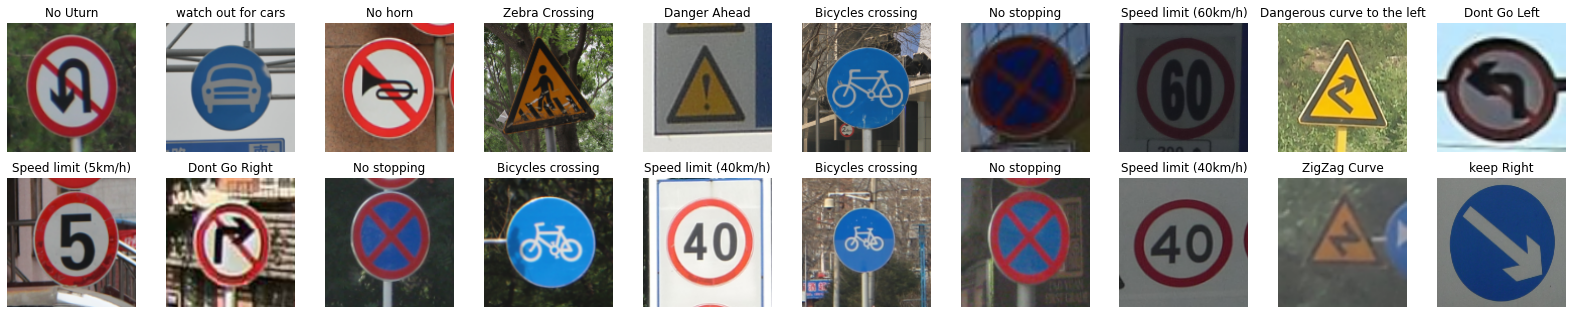

In [70]:
class_numbers = test_generator.class_names
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

#class_names
plt.figure(figsize=(28, 28))
for images, labels in test_generator.take(1):
  for i in range(20):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()


In [71]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
  ]
)

In [72]:
model=keras.Sequential(
    [
        keras.Input(shape=(128,128,3)),
        #data_augmentation,
        layers.Rescaling(1./255),
        layers.Flatten(input_shape=(128,128,3)),
        layers.Dense(256,activation='relu',name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(128,activation='relu'),
        layers.Dense(58,activation='softmax')
    ]
)

print(model.summary())

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)





Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 flatten_11 (Flatten)        (None, 49152)             0         
                                                                 
 layer1 (Dense)              (None, 256)               12583168  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 58)                7482      
                                                                 
Total params: 12,623,546
Trainable params: 12,623,546

In [73]:
history=model.fit(
    train_generator,
    validation_data=valid_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=110,verbose=1
)


Epoch 1/110
104/104 [==============================] - 5s 39ms/step - loss: 3.4054 - accuracy: 0.1965 - val_loss: 2.6105 - val_accuracy: 0.3934
Epoch 2/110
104/104 [==============================] - 4s 39ms/step - loss: 2.6059 - accuracy: 0.3728 - val_loss: 2.1346 - val_accuracy: 0.4949
Epoch 3/110
104/104 [==============================] - 6s 52ms/step - loss: 2.1818 - accuracy: 0.4760 - val_loss: 1.7124 - val_accuracy: 0.6015
Epoch 4/110
104/104 [==============================] - 7s 58ms/step - loss: 1.8677 - accuracy: 0.5361 - val_loss: 1.4633 - val_accuracy: 0.6802
Epoch 5/110
104/104 [==============================] - 4s 37ms/step - loss: 1.6127 - accuracy: 0.6170 - val_loss: 1.2997 - val_accuracy: 0.6701
Epoch 6/110
104/104 [==============================] - 4s 38ms/step - loss: 1.4621 - accuracy: 0.6444 - val_loss: 1.0248 - val_accuracy: 0.7589
Epoch 7/110
104/104 [==============================] - 5s 48ms/step - loss: 1.2638 - accuracy: 0.6891 - val_loss: 0.9238 - val_accuracy:

In [74]:
pred = np.argmax(model.predict(test_generator), axis=-1)
score, accuracy = model.evaluate(test_generator)
print('loss in testing set is:',score,'\naccuracy of testing set:',accuracy*100,'%')

15/15 [==============================] - 1s 17ms/step - loss: 0.0673 - accuracy: 0.9935
loss in testing set is: 0.06725947558879852 
accuracy of testing set: 99.35204982757568 %


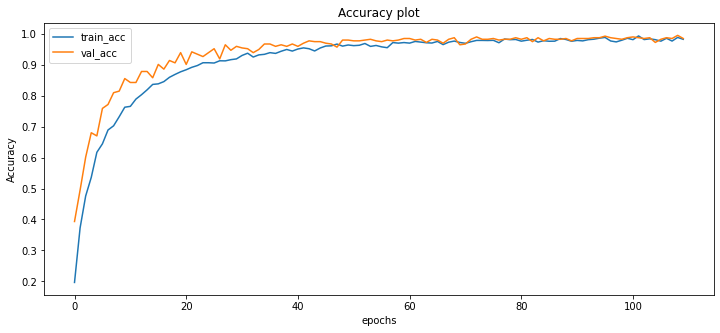

In [75]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy plot')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()